In [ ]:
# import modules
## computer vision
import cv2
## keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

##sklearn
from sklearn.model_selection import train_test_split

## matplotlib
from matplotlib import pyplot as plt

## others
import pandas as pd
import numpy as np
import os

In [ ]:
# mount drive to upload data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# load file
data_file = '/content/drive/My Drive/Face_Mask_Detection/'
dir_path = os.listdir(data_file + 'dataset')
num_labels = [i for i in range(len(dir_path))]
label_dict = dict(zip(dir_path, num_labels))

In [ ]:
num_labels, dir_path, label_dict

([0, 1], ['with mask', 'without mask'], {'with mask': 0, 'without mask': 1})

In [ ]:
# resize the images
img_size = 100
data = []
target = []
for category in dir_path:
    files_path = os.path.join('/content/drive/My Drive/Face_Mask_Detection/dataset', category)
    img_names = os.listdir(files_path)
    
    for img_name in img_names:
        img_path = os.path.join(files_path, img_name)
        img = cv2.imread(img_path)
        
        try: 
            gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # image to gray scale
            resized = cv2.resize(gray_scale, (img_size, img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            
        except Exception as e:
            print('Exception:', e)

In [ ]:
len(target), data[0]

(1376, array([[178, 178, 179, ..., 206, 207, 206],
        [178, 177, 175, ..., 206, 207, 206],
        [178, 178, 178, ..., 206, 207, 206],
        ...,
        [123, 125, 123, ...,  53,  36,  40],
        [123, 124, 123, ..., 105,  36,  41],
        [121, 121, 119, ..., 178,  46,  38]], dtype=uint8))

In [ ]:
# number of without mask images
without_mask = [i for i in range(len(target)) if target[i] == 0]
len(without_mask) # 686 without masks, 690 with_masks(one_hot=0)

690

In [ ]:
# save data
data = np.array(data)/255.0 # 255 is maximum light value, dividing by 255 expresses a 0 to 1 representation. 
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
target = np.array(target)

new_target=np_utils.to_categorical(target) # to categorical one hot vectors

In [ ]:
data.shape

(1376, 100, 100, 1)

In [ ]:
# model
model = Sequential()

#The 1st CNN layer followed by Relu and MaxPooling layers
model.add(Conv2D(200, (3,3), input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# #The 2nd CNN layer followed by Relu and MaxPooling layers
model.add(Conv2D(100, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# flattern layer to stack the output convolutions from 2nd conv layer
model.add(Flatten())
model.add(Dropout(0.5))

# Dense layer
model.add(Dense(50, activation='relu'))
# final layer with two outputs for two labels 
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 200)       2000      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 52900)            

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, new_target, test_size=0.1, random_state=42)

In [ ]:
X_train.shape, y_train.shape, y_test.shape, X_test.shape

((1238, 100, 100, 1), (1238, 2), (138, 2), (138, 100, 100, 1))

In [ ]:
y_train[0:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/Face_Mask_Detection/model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(X_train,y_train,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Train on 990 samples, validate on 248 samples
Epoch 1/20
990/990 [==============================] - 7s 7ms/step - loss: 0.7165 - accuracy: 0.5222 - val_loss: 0.6782 - val_accuracy: 0.4879
Epoch 2/20
990/990 [==============================] - 1s 751us/step - loss: 0.5907 - accuracy: 0.6778 - val_loss: 0.5300 - val_accuracy: 0.7419
Epoch 3/20
990/990 [==============================] - 1s 754us/step - loss: 0.4209 - accuracy: 0.8182 - val_loss: 0.3979 - val_accuracy: 0.8427
Epoch 4/20
990/990 [==============================] - 1s 763us/step - loss: 0.3262 - accuracy: 0.8657 - val_loss: 0.3378 - val_accuracy: 0.8387
Epoch 5/20
990/990 [==============================] - 1s 760us/step - loss: 0.2181 - accuracy: 0.9202 - val_loss: 0.2455 - val_accuracy: 0.8911
Epoch 6/20
990/990 [==============================] - 1s 765us/step - loss: 0.1779 - accuracy: 0.9374 - val_loss: 0.2273 - val_accuracy: 0.9032
Epoch 7/20
990/990 [==============================] - 1s 757us/step - loss: 0.1192 - accurac

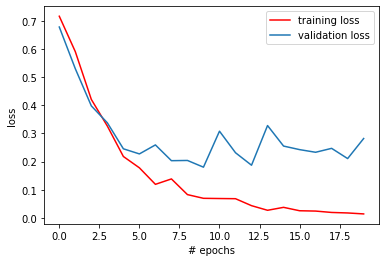

In [ ]:
# loss plots
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

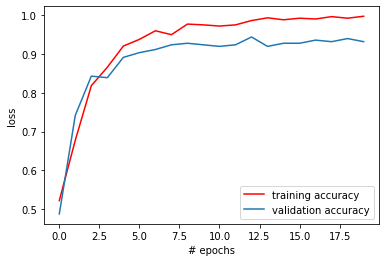

In [ ]:
# accuracy plots
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
print(model.evaluate(X_test,y_test))

138/138 [==============================] - 0s 579us/step
[0.1824217522686619, 0.9637681245803833]


In [ ]:
#pip show keras

Name: Keras
Version: 2.3.1
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, keras-applications, six, scipy, pyyaml, h5py, keras-preprocessing
Required-by: textgenrnn, keras-vis, kapre, fancyimpute
